In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'ONGC.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,18.888887,18.972221,18.777777,18.799999,5.640412,10800
1996-01-02,18.799999,19.277777,18.844444,19.088888,5.727087,27000
1996-01-03,19.333332,19.333332,18.888887,18.888887,5.667082,10800
1996-01-04,18.888887,18.900000,18.500000,18.894444,5.668747,41400
1996-01-05,18.894444,18.905556,18.666666,18.900000,5.670413,46800
...,...,...,...,...,...,...
2024-04-26,283.000000,286.149994,282.200012,282.899994,282.899994,11070290
2024-04-29,283.950012,285.250000,282.149994,283.200012,283.200012,8952420
2024-04-30,284.500000,286.350006,281.450012,282.850006,282.850006,10658906


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 26s 81ms/step - loss: 0.0063
Epoch 2/50
221/221 [==============================] - 18s 79ms/step - loss: 0.0023
Epoch 3/50
221/221 [==============================] - 23s 103ms/step - loss: 0.0020
Epoch 4/50
221/221 [==============================] - 30s 134ms/step - loss: 0.0017
Epoch 5/50
221/221 [==============================] - 24s 106ms/step - loss: 0.0016
Epoch 6/50
221/221 [==============================] - 17s 76ms/step - loss: 0.0014
Epoch 7/50
221/221 [==============================] - 16s 73ms/step - loss: 0.0014
Epoch 8/50
221/221 [==============================] - 17s 76ms/step - loss: 0.0012
Epoch 9/50
221/221 [==============================] - 21s 94ms/step - loss: 0.0011
Epoch 10/50
221/221 [==============================] - 21s 94ms/step - loss: 0.0011
Epoch 11/50
221/221 [==============================] - 28s 125ms/step - loss: 0.0011
Epoch 12/50
221/221 [==============================] - 24s 109ms/step - loss: 9.8

1/1 [==============================] - 0s 35ms/step


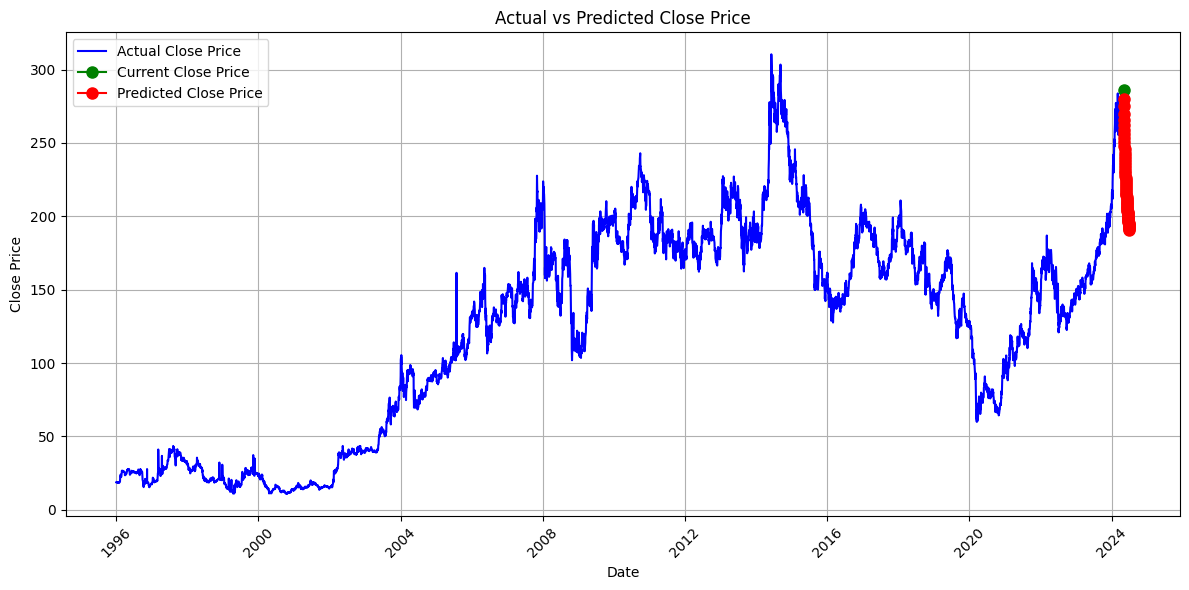

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices


array([280.27853, 275.15698, 270.04044, 265.74783, 262.15814, 259.01602,
       256.13745, 253.41364, 250.79132, 248.25209, 245.79538, 243.42705,
       241.1529 , 238.97615, 236.89673, 234.912  , 233.01747, 231.20787,
       229.47748, 227.82079, 226.23248, 224.70775, 223.24211, 221.83154,
       220.47238, 219.16129, 217.89523, 216.67142, 215.48734, 214.34067,
       213.22928, 212.15121, 211.10472, 210.0881 , 209.09988, 208.13863,
       207.203  , 206.29189, 205.40408, 204.53857, 203.69435, 202.87056,
       202.06624, 201.28067, 200.51302, 199.7626 , 199.02872, 198.31075,
       197.60806, 196.9201 , 196.24632, 195.58621, 194.93925, 194.30501,
       193.68298, 193.07283, 192.47408, 191.88638, 191.30934, 190.74265],
      dtype=float32)

In [10]:
model.save('ONGC.h5')


c:\Users\user\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'ONGC.pkl')

['ONGC.pkl']